In [1]:
import healpy as hp
import numpy as np
from astropy.cosmology import FlatLambdaCDM,z_at_value
import astropy.units as u
import matplotlib.pyplot as plt
DIR_SKYMAP='/global/homes/w/wballard/standard-sirens/'
skymap='GW190412_skymap.fits.gz'
nevent=1

skymap_name=DIR_SKYMAP+skymap
print(skymap_name)
H0_min=20
H0_max=140
Omega_m=0.3
z_min=0.001
z_max=0.5
extinction_coeff=2.165

pb,distmu,distsigma,distnorm=hp.read_map(skymap_name,field=range(4),memmap=True)
NSIDE=hp.npix2nside(len(pb))
pixarea=hp.nside2pixarea(NSIDE)
pixarea_deg=hp.nside2pixarea(NSIDE,degrees=True)
pb_frac=0.90

/global/homes/w/wballard/standard-sirens/GW190412_skymap.fits.gz


In [2]:
from scipy import interpolate
def dist_mod(z_vals,d='/global/homes/w/wballard/standard-sirens/'):
   z = np.load(d+'dist_mod_kcorr.npz')['z']
   dm = np.load(d+'dist_mod_kcorr.npz')['dm']
   f_dm = interpolate.interp1d(z, dm, kind='cubic', bounds_error=False, fill_value=0)
   return f_dm(z_vals)

In [3]:

from astropy.io import fits
DIR_CATALOG='/global/homes/w/wballard/standard-sirens/'
glxcat='reducedCatalogNoBGS.fits'
ra_column_name='TARGET_RA'
dec_column_name='TARGET_DEC'
z_column_name='Z'
zerr_column_name='ZERR'
flux_column_name='FLUX_R'
catalog_name = DIR_CATALOG+glxcat

h=fits.open(catalog_name,memmap=True)[1].data
flux_g=h[flux_column_name]
z_g=h[z_column_name]
ra_g=h[ra_column_name]
dec_g=h[dec_column_name]
zerr_g=h[zerr_column_name]

pix_g=h['hpix1024']
ebv_g=h['EBV']
weight_g = np.ones_like(ra_g)
#print(np.max(flux_g))


In [4]:
if(glxcat=="reducedCatalogNoBGS.fits"):
    flux_mask=flux_g>0
    flux_g=flux_g[flux_mask]
    z_g=z_g[flux_mask]
    ra_g=ra_g[flux_mask]
    dec_g=dec_g[flux_mask]
    zerr_g=zerr_g[flux_mask]
    pix_g=pix_g[flux_mask]
    ebv_g=ebv_g[flux_mask]
    weight_g=weight_g[flux_mask]

In [5]:
transmission_mw=ebv_g*extinction_coeff
corrected_flux=flux_g/transmission_mw
omag_g=22.5-2.5*np.log10(corrected_flux) #from legacy survey webpage
abs_mag=omag_g-dist_mod(z_g)
abs_mag_cut=abs_mag<-21.5
flux=flux_g[abs_mag_cut]
z=z_g[abs_mag_cut]
ra=ra_g[abs_mag_cut]
dec=dec_g[abs_mag_cut]
zerr=zerr_g[abs_mag_cut]
pix=pix_g[abs_mag_cut]
weight=weight_g[abs_mag_cut]

In [6]:
i = np.flipud(np.argsort(pb))
sorted_credible_levels = np.cumsum(pb[i])
credible_levels = np.empty_like(sorted_credible_levels)
credible_levels[i] = sorted_credible_levels



In [7]:

mask=(credible_levels<=pb_frac)
cred_cut=credible_levels[mask]

roi_area=np.sum(mask) * hp.nside2pixarea(NSIDE, degrees=True)

ramax,decmax=hp.pix2ang(NSIDE,np.argmax(pb),lonlat=True)

distmu_avg=np.average(distmu[mask],weights=pb[mask])
distsig_avg=np.average(distsigma[mask],weights=pb[mask])




In [8]:

cosmomin=FlatLambdaCDM(H0=H0_min,Om0=Omega_m)
cosmomax=FlatLambdaCDM(H0=H0_max,Om0=Omega_m)
nsigma=1.65
H0_array = np.linspace(H0_min,H0_max,num=101)
d_min=distmu_avg-(nsigma*distsig_avg)
d_max=distmu_avg+(nsigma*distsig_avg)
z_min=max(z_min,z_at_value(cosmomin.luminosity_distance,d_min*u.Mpc,zmin=1e-5,zmax=2,method='bounded'))
z_max=min(z_max,z_at_value(cosmomax.luminosity_distance,d_max*u.Mpc,zmin=1e-5,zmax=2,method='bounded'))





In [9]:
idx_sort = np.argsort(pb)
idx_sort_up = list(reversed(idx_sort))
sum = 0.
id = 0
print("Selecting glaxies in pixels sorted by PROB value...")
while sum<pb_frac:
    this_idx = idx_sort_up[id]
    sum = sum+pb[this_idx]
    id = id+1
idx_sort_cut = idx_sort_up[:id]

Selecting glaxies in pixels sorted by PROB value...


In [10]:
mask_z = np.logical_and((z>z_min),(z<z_max))
ra_glx=ra[mask_z]
dec_glx=dec[mask_z]
z_glx=z[mask_z]
zerr_glx=zerr[mask_z]
pix_glx=pix[mask_z]
weight_glx=weight[mask_z]/weight[mask_z].sum()
in_region=np.where(np.isin(pix_glx,idx_sort_cut))
print(in_region)


(array([1133434, 1133435, 1133436, ..., 4954196, 4954197, 4954198]),)


In [11]:

z_gal = z_glx[in_region]
zerr_gal = zerr_glx[in_region]
ra_gal = ra_glx[in_region] 
dec_gal = dec_glx[in_region] 
pix_gal = pix_glx[in_region]
weight_gal=weight_glx[in_region]

pb_gal =  np.zeros_like(ra_gal)
distmu_gal =  np.zeros_like(ra_gal)
distsigma_gal =  np.zeros_like(ra_gal)
distnorm_gal = np.zeros_like(ra_gal)

for i in idx_sort_cut:
    this_pix=(pix_gal==i)
    pb_gal[this_pix]=pb[i]
    distmu_gal[this_pix]=distmu[i]
    distsigma_gal[this_pix]=distsigma[i]
    distnorm_gal[this_pix]=distnorm[i]

ngals = ra_gal.shape[0]
print("There are ", str(ngals), " galaxies within ", str(pb_frac*100.), "%, and z between ", z_min, z_max)

There are  15374  galaxies within  90.0 %, and z between  0.03881960508712149 redshift 0.32294708140538037 redshift


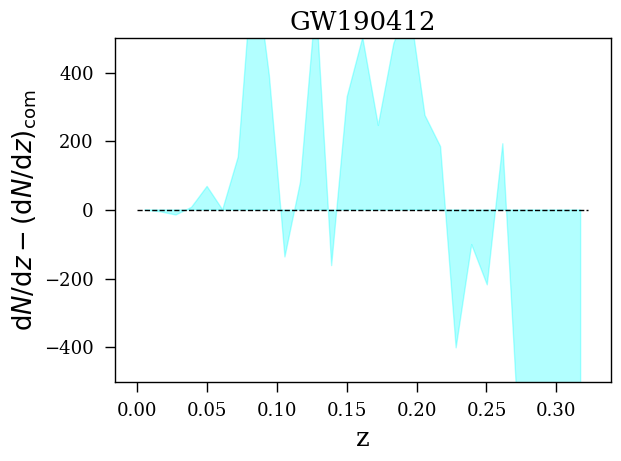

In [12]:
import sys
sys.stderr=open('error.log','w',buffering=1)

def plt_style():
    plt.rcParams.update({
                        'lines.linewidth':1.0,
                        'lines.linestyle':'-',
                        'lines.color':'black',
                        'font.family':'serif',
                        'font.weight':'normal',
                        'font.size':13.0,
                        'text.color':'black',
                        'text.usetex':False,
                        'axes.edgecolor':'black',
                        'axes.linewidth':1.0,
                        'axes.grid':False,
                        'axes.titlesize':'x-large',
                        'axes.labelsize':'x-large',
                        'axes.labelweight':'normal',
                        'axes.labelcolor':'black',
                        'axes.formatter.limits':[-4,4],
                        'xtick.major.size':7,
                        'xtick.minor.size':4,
                        'xtick.major.pad':8,
                        'xtick.minor.pad':8,
                        'xtick.labelsize':'medium',
                        'xtick.minor.width':1.0,
                        'xtick.major.width':1.0,
                        'ytick.major.size':7,
                        'ytick.minor.size':4,
                        'ytick.major.pad':8,
                        'ytick.minor.pad':8,
                        'ytick.labelsize':'medium',
                        'ytick.minor.width':1.0,
                        'ytick.major.width':1.0,
                        'legend.numpoints':1,
                        #'legend.fontsize':'x-large',
                        'legend.shadow':False,
                        'legend.frameon':False})

table20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

event='GW190412'
cosmo=FlatLambdaCDM(H0=70,Om0=0.3)


bins=np.linspace(0,z_max,num=30)
zbins = np.zeros(bins.shape[0]-1)
for i in range(bins.shape[0]-1): 
    zbins[i]=(bins[i+1]+bins[i])/2.






mean_z,zbins_e=np.histogram(z_gal,bins=bins)

plt.clf()
plt_style()

dV = cosmo.differential_comoving_volume(zbins).value

norm_mean=mean_z.sum()
dV_n=dV/dV.sum()*norm_mean
plt.fill_between(zbins,mean_z-dV_n, np.full(len(mean_z),0.), label='Mean Z',color='aqua',alpha=0.3)

plt.xlabel('z')
plt.ylabel(r'${\rm d} N/{\rm d}z - ({\rm d}N/{\rm d}z)_{\rm com}$')
plt.plot([0,z_max],[0.,0.], 'k--')
plt.ylim(-500,500)
plt.title(event+"")
plt.tight_layout()
#plt.savefig('GW190412_NoCut.png',dpi=200)




In [13]:
import posterior_utils as pos
zarr = np.linspace(z_min,z_max,num=1+2**10)
gzarr = np.zeros((ngals,zarr.size))
z_norm = np.linspace(z_min,z_max,num=200)
for i in range(ngals):
    g = pos.gauss(z_gal[i],zerr_gal[i],zarr)
    g_norm = pos.gauss(z_gal[i],zerr_gal[i],z_norm)
    norm = 1.e-300+np.trapz(g_norm,z_norm)
    gzarr[i] = g/norm

In [14]:

def lnpost(H0value):
        return pos.lnprob(H0value, z_gal, zerr_gal, weight_gal, pb_gal, distmu_gal, distsigma_gal, distnorm_gal, pixarea, H0_min, H0_max, z_min, z_max, zerr_use=True, cosmo_use=True ,omegam=Omega_m,gauss_z_array=gzarr,z_s=zarr,hpix=pix_gal,d50=638,use_zPDF=False,bias_marginalize=False,bias_mean=0, z_bias_bins_edges=0)
lnposterior=[]
for H0value in H0_array:
        lnp=lnpost(H0value)
        lnposterior.append(lnp)



Applying blinding factor. Saving value on  /global/homes/w/wballard/standard-sirens/out/blinding_file.p


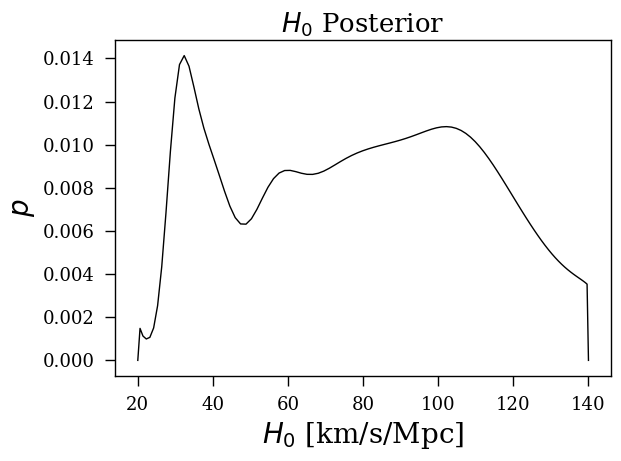

In [15]:

n_H0_maxlike=[]
n_H0_err_p=[]
n_H0_err_m=[]
n_H0_median=[]
cl=0.68
DIR_OUT='/global/homes/w/wballard/standard-sirens/out/'
outlabel='H0 Posterior'
posterior=np.exp(lnposterior)
#Output stuff
blindpath = DIR_OUT+"blinding_file.p"
H0_blinded_array=pos.make_blind(H0_array,H0_min,H0_max,blindpath)
print("Applying blinding factor. Saving value on ", blindpath)
H0_array_out = H0_blinded_array
H0_maxlike, H0_err_p , H0_err_m  = pos.cl_range(H0_array_out,posterior,cl=cl)
H0_median=pos.percentile(0.50, posterior, H0_array_out)
n_H0_maxlike.append(H0_maxlike)
n_H0_err_p.append(H0_err_p)
n_H0_err_m.append(H0_err_m)
n_H0_median.append(H0_median)
header = "H0_Blinded"
fmt = "%10.5f"


norm = 1.e-300+np.trapz(posterior, H0_array_out)
posterior = posterior/norm 
dl=int(distmu_avg)
plt.plot(H0_array_out, posterior, label="Event"+str(1)+": "+str(dl)+" Mpc")
fmt=fmt+" %10.6e"
header = header+" Posterior_"+str(1)

cols = np.column_stack((H0_array_out,posterior))
header = header.split()[0]+" Posterior"
plt.clf()
dl=int(distmu_avg)
plt.plot(H0_array_out, posterior, color='k', label=str(dl)+" Mpc")

plt.xlabel('$H_0$ [km/s/Mpc]',fontsize=20)
plt.ylabel('$p$',fontsize=20)
plt.title('$H_0$ Posterior')
plt.tight_layout()
outfile = open(DIR_OUT+outlabel+'_summary_final.txt','w')
outfile.write('# H0_maxlike H0_errp H0_errm H0_median\n')
outfile.write('%f %f %f %f \n' % (H0_maxlike, H0_err_p, H0_err_m, H0_median))
outfile.close()
#plt.savefig(DIR_OUT+'H0_posterior95.png')